In [19]:
import torch
import numpy as np
import os
import time
import glob
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/Users/sarahurbut/aladynoulli2/pyScripts/')
from cluster_g_logit_init_acceptpsi_flatlam_healthtoo import *
import sys
sys.dont_write_bytecode = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:



# Base directory containing all output folders
#base_dir = '/Users/sarahurbut/Dropbox (Personal)/from_AWS/resultstraj/'
base_dir = '/Users/sarahurbut/Dropbox/resultstraj_genetic_scale1/results/'
# List all output directories
output_dirs = sorted(glob.glob(os.path.join(base_dir, 'output_*')))

first_model = torch.load(os.path.join(base_dir, 'output_0_10000/model.pt'))

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_8488/3341586209.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  first_model = torch.load(os.path.join(base_dir

In [10]:
disease_names = first_model['disease_names']
disease_names = disease_names[0].tolist()

In [12]:
# Load first model to get phi_kd
phi_kd = first_model['model_state_dict']['phi']  # Shape should be (K, D)
all_lambdas = np.load('/Users/sarahurbut/aladynoulli2/pyScripts/oldstuff/all_lambdas_combined_smallg.npy')
# Calculate pi for all people
# all_lambdas shape is (N, K, T)
# phi_kd shape is (K, D)
# Need to calculate for each timepoint
T = all_lambdas.shape[2]
D = phi_kd.shape[1]


In [13]:
first_model['model_state_dict']['gamma'].shape

torch.Size([36, 21])

In [14]:
# Extract the values
lambda1 = first_model['model_state_dict']['lambda_'][2701,:,:]
lambda2 = torch.tensor(all_lambdas[2701,:,:], dtype=lambda1.dtype)  # Match the dtype of lambda1

# Print first few values of each
print("first_model lambda first 5 values:", lambda1[:5])
print("all_lambdas first 5 values:", lambda2[:5])

# Print dtypes to verify
print("\nDtype of lambda1:", lambda1.dtype)
print("Dtype of lambda2:", lambda2.dtype)

# Check if they're equal
print("\nAre they exactly equal?", torch.allclose(lambda1, lambda2))

# If they're not equal, print the difference statistics
if not torch.allclose(lambda1, lambda2):
    diff = lambda1 - lambda2
    print("\nDifference statistics:")
    print("Mean difference:", torch.mean(diff))
    print("Max absolute difference:", torch.max(torch.abs(diff)))
    print("Min absolute difference:", torch.min(torch.abs(diff)))

first_model lambda first 5 values: tensor([[-5.0789, -5.0198, -4.9616, -4.9043, -4.8479, -4.7923, -4.7376, -4.6837,
         -4.6314, -4.5812, -4.5320, -4.4853, -4.4445, -4.4066, -4.3677, -4.3282,
         -4.2892, -4.2494, -4.2085, -4.1662, -4.1207, -4.0718, -4.0205, -3.9684,
         -3.9154, -3.8607, -3.8035, -3.7442, -3.6839, -3.6235, -3.5639, -3.5054,
         -3.4470, -3.3873, -3.3266, -3.2664, -3.2082, -3.1524, -3.0982, -3.0454,
         -2.9938, -2.9449, -2.9001, -2.8595, -2.8219, -2.7839, -2.7458, -2.7087,
         -2.6727, -2.6375, -2.6029, -2.5684],
        [-2.7610, -2.7543, -2.7466, -2.7379, -2.7282, -2.7175, -2.7057, -2.6919,
         -2.6757, -2.6582, -2.6387, -2.6167, -2.5933, -2.5693, -2.5451, -2.5208,
         -2.4974, -2.4747, -2.4523, -2.4320, -2.4155, -2.4032, -2.3943, -2.3877,
         -2.3835, -2.3823, -2.3843, -2.3890, -2.3955, -2.4029, -2.4113, -2.4220,
         -2.4352, -2.4503, -2.4670, -2.4849, -2.5044, -2.5260, -2.5495, -2.5753,
         -2.6031, -2.6320, -

In [15]:
# Convert to thetas first
all_thetas = torch.softmax(torch.tensor(all_lambdas), dim=1).numpy()

epsilon = 1e-8
# Convert lambdas to thetas


# Get phi probabilities
phi_prob = torch.sigmoid(torch.tensor(phi_kd)).numpy()



/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_8488/395423456.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  phi_prob = torch.sigmoid(torch.tensor(phi_kd)).numpy()


In [16]:
# 1. Full calculation
print("Starting full calculation...")
start_time = time.time()
pi_pred = np.einsum('nkt,kdt->ndt', all_thetas, phi_prob)
print(f"Full calculation took: {(time.time() - start_time)/60:.2f} minutes")

# 2. Additional verification
print("\nVerification:")
print(f"Full pi shape: {pi_pred.shape}")
print(f"Range of values: [{pi_pred.min():.6f}, {pi_pred.max():.6f}]")
print(f"Mean value: {pi_pred.mean():.6f}")

Starting full calculation...
Full calculation took: 3.21 minutes

Verification:
Full pi shape: (400000, 348, 52)
Range of values: [0.000000, 0.013071]
Mean value: 0.000144


In [17]:
predicted_risk_2d = np.mean(pi_pred, axis=0)  # Shape will be (348, 52)

print("Predicted risk shape:", predicted_risk_2d.shape)  # Should be (348, 52)
print("Range of values:", predicted_risk_2d.min(), predicted_risk_2d.max())
print("Mean value:", predicted_risk_2d.mean())

Predicted risk shape: (348, 52)
Range of values: 3.067067230898189e-09 0.008809546076733633
Mean value: 0.0001443116403092785


In [20]:
def load_model_essentials(base_path='/Users/sarahurbut/Dropbox (Personal)/data_for_running/'):
    """
    Load all essential components
    """
    print("Loading components...")
    
    # Load large matrices
    Y = torch.load(base_path + 'Y_tensor.pt')
    E = torch.load(base_path + 'E_matrix.pt')
    G = torch.load(base_path + 'G_matrix.pt')
    
    # Load other components
    essentials = torch.load(base_path + 'model_essentials.pt')
    
    print("Loaded all components successfully!")
    
    return Y, E, G, essentials

# Load and initialize model:
Y, E, G, essentials = load_model_essentials()

# Function to find interesting

Loading components...


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_8488/1032044898.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Y = torch.load(base_path + 'Y_tensor.pt')


FileNotFoundError: [Errno 2] No such file or directory: '/Users/sarahurbut/Dropbox (Personal)/data_for_running/Y_tensor.pt'

In [12]:
# Get μ_dt from checkpoint and predictions
mu_dt = first_model['prevalence_t']  # Shape: (348, 52)
scale_factor = np.mean(mu_dt) / np.mean(predicted_risk_2d)
print(scale_factor)


2.7771012964409887


In [16]:
# Raw event rates from Y
observed_events = Y.mean(dim=0).numpy()  # Shape should match your predictions
unsmoothed_scale_factor = np.mean(observed_events) / np.mean(predicted_risk_2d)
print(f"Unsmoothed scale factor: {unsmoothed_scale_factor}")

Unsmoothed scale factor: 3.086132198773139


## first plot versus smoothed incidence

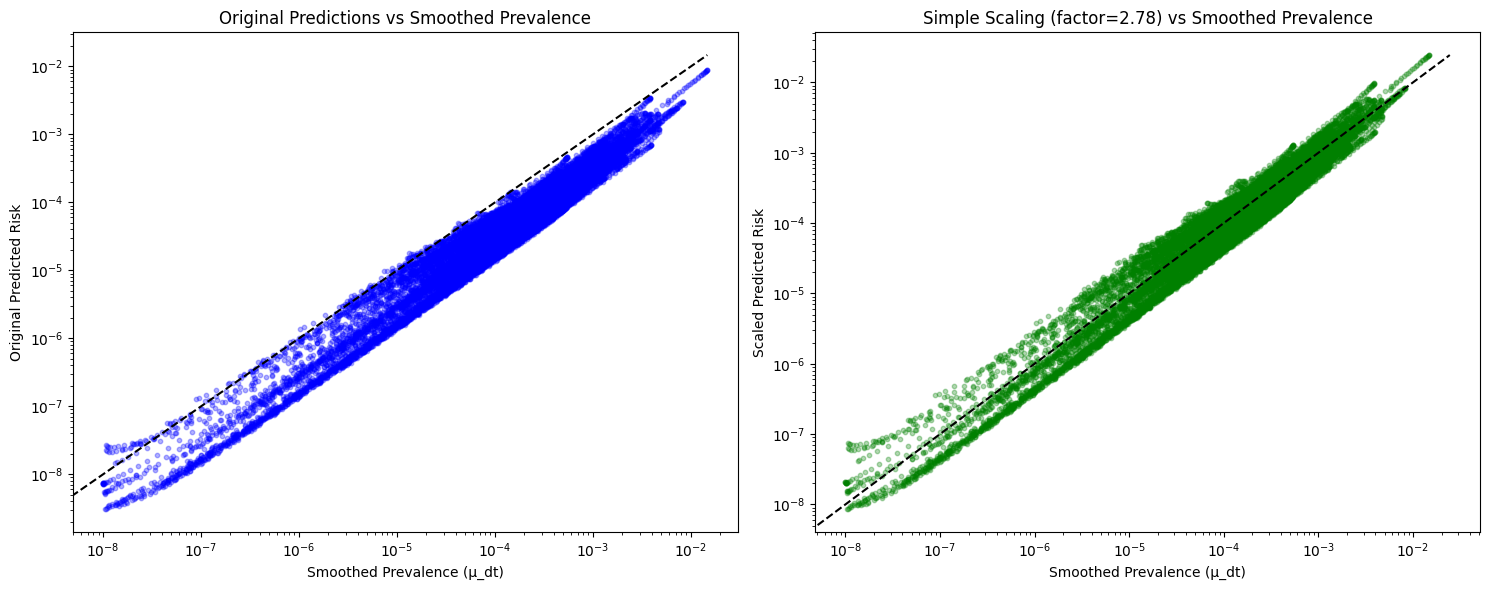

In [17]:

scaled_risk_2d = predicted_risk_2d * scale_factor

# Create two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Original predictions vs μ_dt
ax1.scatter(mu_dt.flatten(), predicted_risk_2d.flatten(), 
           alpha=0.3, color='blue', s=10)
ax1.plot([0, max(mu_dt.max(), predicted_risk_2d.max())], 
         [0, max(mu_dt.max(), predicted_risk_2d.max())], 
         'k--', label='x=y')
ax1.set_xlabel('Smoothed Prevalence (μ_dt)')
ax1.set_ylabel('Original Predicted Risk')
ax1.set_title('Original Predictions vs Smoothed Prevalence')
ax1.set_xscale('log')
ax1.set_yscale('log')

# Scaled predictions vs μ_dt
ax2.scatter(mu_dt.flatten(), scaled_risk_2d.flatten(), 
           alpha=0.3, color='green', s=10)
ax2.plot([0, max(mu_dt.max(), scaled_risk_2d.max())], 
         [0, max(mu_dt.max(), scaled_risk_2d.max())], 
         'k--', label='x=y')
ax2.set_xlabel('Smoothed Prevalence (μ_dt)')
ax2.set_ylabel('Scaled Predicted Risk')
ax2.set_title(f'Simple Scaling (factor={scale_factor:.2f}) vs Smoothed Prevalence')
ax2.set_xscale('log')
ax2.set_yscale('log')

plt.tight_layout()
plt.show()

In [18]:
def print_disease_names(base_dir):
    """
    Print disease names from the first model's DataFrame
    """
    # Load first model
    first_model = torch.load(os.path.join(base_dir, 'output_0_10000/model.pt'))
    
    # Get disease names DataFrame
    disease_names_df = first_model['disease_names']
    
    print("\nAvailable diseases:")
    # Assuming the disease names are in a column - let's see the structure
    print("\nDataFrame structure:")
    print(disease_names_df.head())
    print("\nColumns:", disease_names_df.columns.tolist())
    
    return disease_names_df

# Look at the disease names DataFrame structure
disease_names_df = print_disease_names(base_dir)

/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_171/3415850116.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  first_model = torch.load(os.path.join(base_dir,


Available diseases:

DataFrame structure:
                           0
0        Bacterial enteritis
1            Viral Enteritis
2   Gram negative septicemia
3    Bacterial infection NOS
4  Staphylococcus infections

Columns: [0]


## should we calibrate to bserved (noisy Y) or smoothed (mu_dt) ? should we calibrate per disease?


Smoothed scale factor: 3.3748767910631536
Unsmoothed scale factor: 2.332023021075034


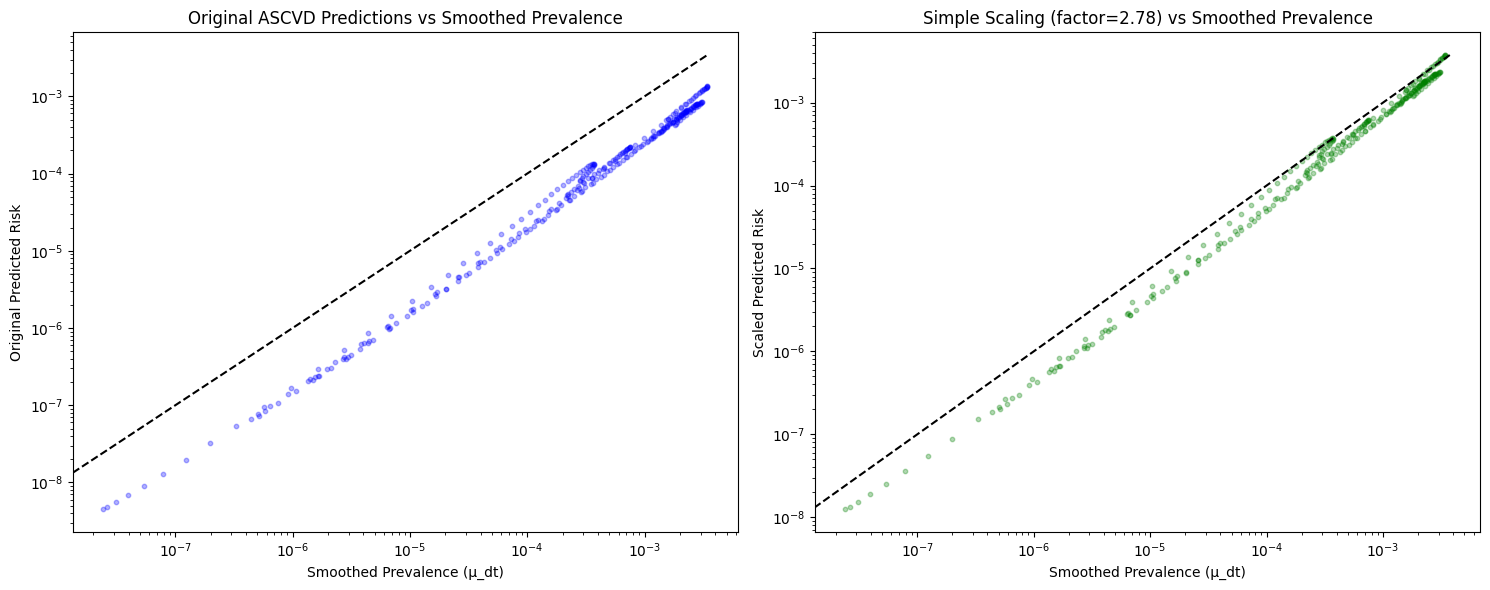

In [25]:
def calibrate_ascvd_hazards(pi_pred, first_model):
    """
    Calibrate ASCVD hazards using population-level rates
    """
    ascvd_indices = [111, 112, 113, 114, 115, 116]
    
    # Get mean predictions across patients for each ASCVD condition and timepoint
    pred_risk = pi_pred[:, ascvd_indices, :].mean(axis=0)  # Shape: [6 diseases, 52 timepoints]
    
    # Get preva# Get prevalence for ASCVD conditions
    if torch.is_tensor(first_model['prevalence_t']):
        mu_dt = first_model['prevalence_t'][ascvd_indices].cpu().numpy()
    else:
        mu_dt = first_model['prevalence_t'][ascvd_indices]

    # Smoothed scaling factor
    smoothed_scale_factor = np.mean(mu_dt) / np.mean(pred_risk)

    # Unsmoothed scaling factor using actual ASCVD events
    observed_ascvd_events = Y[ascvd_indices].mean(dim=0).cpu().numpy()
    unsmoothed_scale_factor = np.mean(observed_ascvd_events) / np.mean(pred_risk)

    print(f"Smoothed scale factor: {smoothed_scale_factor}")
    print(f"Unsmoothed scale factor: {unsmoothed_scale_factor}")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Original predictions vs μ_dt
    ax1.scatter(mu_dt.flatten(), pred_risk.flatten(), 
               alpha=0.3, color='blue', s=10)
    ax1.plot([0, max(mu_dt.max(), pred_risk.max())], 
             [0, max(mu_dt.max(), pred_risk.max())], 
             'k--', label='x=y')
    ax1.set_xlabel('Smoothed Prevalence (μ_dt)')
    ax1.set_ylabel('Original Predicted Risk')
    ax1.set_title('Original ASCVD Predictions vs Smoothed Prevalence')
    ax1.set_xscale('log')
    ax1.set_yscale('log')

    # Scaled predictions vs μ_dt
    scaled_risk = pred_risk * scale_factor
    ax2.scatter(mu_dt.flatten(), scaled_risk.flatten(), 
               alpha=0.3, color='green', s=10)
    ax2.plot([0, max(mu_dt.max(), scaled_risk.max())], 
             [0, max(mu_dt.max(), scaled_risk.max())], 
             'k--', label='x=y')
    ax2.set_xlabel('Smoothed Prevalence (μ_dt)')
    ax2.set_ylabel('Scaled Predicted Risk')
    ax2.set_title(f'Simple Scaling (factor={scale_factor:.2f}) vs Smoothed Prevalence')
    ax2.set_xscale('log')
    ax2.set_yscale('log')

    plt.tight_layout()
    plt.show()
    

        
    return smoothed_scale_factor,unsmoothed_scale_factor 

ascvd_scale_smooth,ascvd_scale_unsmooth=calibrate_ascvd_hazards(pi_pred=pi_pred,first_model=first_model)

In [26]:
ascvd_scale_smooth

np.float64(3.3748767910631536)

In [27]:
patient_ids=np.load('/Users/sarahurbut/aladynoulli2/pyScripts/npys/processed_patient_ids.npy')

In [33]:
import pandas as pd 
# Try reading with rpy2 explicitly preserving row names
from rpy2.robjects import r

# Read with explicit row.names preservation
r('''
read_rds_with_names <- function(path) {
    df <- readRDS(path)
    attr(df, "row.names") <- rownames(df)
    df
}
''')

pce_df = r['read_rds_with_names']('/Users/sarahurbut/Dropbox (Personal)/pce_withnames.rds')

# Convert to pandas with index
pce_array = np.array(pce_df)
ages = range(40, 80)
pce_df = pd.DataFrame(pce_array, columns=ages)

# Print what we got
print("Shape:", pce_df.shape)
print("\nFirst few rows:")
print(pce_df.head())

# Or alternatively, we could read the row names separately:
row_names = r('rownames(readRDS("/Users/sarahurbut/Dropbox (Personal)/pce_withnames.rds"))')
pce_df.index = np.array(row_names)


Shape: (79117, 40)

First few rows:
     40    41    42    43    44    45    46    47    48    49  ...     70  \
0  3.25  3.63  4.05  4.50  4.98  5.51  6.08  6.69  7.34  8.04  ...  35.06   
1  2.05  2.30  2.56  2.85  3.16  3.50  3.86  4.25  4.67  5.12  ...  23.55   
2  1.00  1.00  1.00  1.00  1.00  1.00  1.04  1.13  1.22  1.33  ...  10.64   
3  1.89  1.95  2.02  2.11  2.21  2.33  2.46  2.60  2.76  2.94  ...  16.06   
4  1.31  1.38  1.46  1.56  1.67  1.79  1.93  2.08  2.25  2.44  ...  18.03   

      71     72     73     74     75     76     77     78     79  
0  36.92  38.82  40.75  42.72  44.71  46.73  48.77  50.82  52.88  
1  24.91  26.32  27.77  29.26  30.80  32.37  33.98  35.62  37.30  
2  11.80  13.09  14.51  16.07  17.79  19.68  21.74  23.98  26.42  
3  17.53  19.13  20.86  22.73  24.76  26.94  29.29  31.80  34.48  
4  19.88  21.90  24.10  26.49  29.08  31.86  34.85  38.04  41.42  

[5 rows x 40 columns]


In [31]:
# Get the row names from R
row_names = np.array(r('rownames(readRDS("/Users/sarahurbut/Dropbox (Personal)/pce_withnames.rds"))'))

# Create DataFrame with proper row names and age columns
pce_array = np.array(pce_df)
ages = range(40, 80)
pce_df = pd.DataFrame(pce_array, index=row_names, columns=ages)

print("Shape:", pce_df.shape)
print("\nFirst few rows:")
print(pce_df.head())

# Verify we have the right structure
print("\nIndex (row names) sample:", pce_df.index[:6])
print("Columns (ages):", pce_df.columns.tolist()[:5], "...", pce_df.columns.tolist()[-5:])

Shape: (79117, 40)

First few rows:
           40    41    42    43    44    45    46    47    48    49  ...  \
5021704  3.25  3.63  4.05  4.50  4.98  5.51  6.08  6.69  7.34  8.04  ...   
5021715  2.05  2.30  2.56  2.85  3.16  3.50  3.86  4.25  4.67  5.12  ...   
5021723  1.00  1.00  1.00  1.00  1.00  1.00  1.04  1.13  1.22  1.33  ...   
5021737  1.89  1.95  2.02  2.11  2.21  2.33  2.46  2.60  2.76  2.94  ...   
5021742  1.31  1.38  1.46  1.56  1.67  1.79  1.93  2.08  2.25  2.44  ...   

            70     71     72     73     74     75     76     77     78     79  
5021704  35.06  36.92  38.82  40.75  42.72  44.71  46.73  48.77  50.82  52.88  
5021715  23.55  24.91  26.32  27.77  29.26  30.80  32.37  33.98  35.62  37.30  
5021723  10.64  11.80  13.09  14.51  16.07  17.79  19.68  21.74  23.98  26.42  
5021737  16.06  17.53  19.13  20.86  22.73  24.76  26.94  29.29  31.80  34.48  
5021742  18.03  19.88  21.90  24.10  26.49  29.08  31.86  34.85  38.04  41.42  

[5 rows x 40 columns]

Ind

In [34]:

processed_ids=patient_ids
# Get intersection
pce_ids = set(pce_df.index)
processed_ids_set = set(processed_ids)
common_ids = pce_ids.intersection(processed_ids_set)

print(f"PCE patients: {len(pce_ids):,}")
print(f"Processed patients: {len(processed_ids_set):,}")
print(f"Intersection: {len(common_ids):,}")

# Convert intersection to list and sort for consistency
common_ids = sorted(list(common_ids))

# Create a subset of PCE data for just the overlapping patients
pce_subset = pce_df.loc[common_ids]
print("\nShape of PCE subset:", pce_subset.shape)
print("\nFirst few rows of subset:")
print(pce_subset.head())

PCE patients: 79,117
Processed patients: 400,000
Intersection: 59,896

Shape of PCE subset: (59896, 40)

First few rows of subset:
           40    41    42    43    44    45    46    47    48    49  ...  \
5021715  2.05  2.30  2.56  2.85  3.16  3.50  3.86  4.25  4.67  5.12  ...   
5021723  1.00  1.00  1.00  1.00  1.00  1.00  1.04  1.13  1.22  1.33  ...   
5021737  1.89  1.95  2.02  2.11  2.21  2.33  2.46  2.60  2.76  2.94  ...   
5021742  1.31  1.38  1.46  1.56  1.67  1.79  1.93  2.08  2.25  2.44  ...   
5021759  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  ...   

            70     71     72     73     74     75     76     77     78     79  
5021715  23.55  24.91  26.32  27.77  29.26  30.80  32.37  33.98  35.62  37.30  
5021723  10.64  11.80  13.09  14.51  16.07  17.79  19.68  21.74  23.98  26.42  
5021737  16.06  17.53  19.13  20.86  22.73  24.76  26.94  29.29  31.80  34.48  
5021742  18.03  19.88  21.90  24.10  26.49  29.08  31.86  34.85  38.04  41.42  
5021759   7.

## Now we will use the calibrated ascvd preds to predict ten year risk, using the smoothed

In [35]:
# Get indices for ASCVD conditions and our common patients
ascvd_indices = [111, 112, 113, 114, 115, 116]

patient_mask = np.isin(patient_ids, common_ids)

# Extract predictions just for these patients and ASCVD conditions
ascvd_preds = pi_pred[patient_mask][:, ascvd_indices, :]

# Apply calibration factor
ascvd_preds_calibrated = ascvd_preds * ascvd_scale_smooth

print("Shape of calibrated predictions:", ascvd_preds_calibrated.shape)
print("Should be (n_common_patients, n_ascvd_conditions, n_timepoints)")
print(f"Expected: ({len(common_ids)}, 6, 52)")

# Verify we got the right patients
print("\nFirst few patient indices:", common_ids[:5])
print("\nSample of calibrated predictions for first patient, first condition:")
print(ascvd_preds_calibrated[0, 0, :10])  # First 10 timepoints

Shape of calibrated predictions: (59896, 6, 52)
Should be (n_common_patients, n_ascvd_conditions, n_timepoints)
Expected: (59896, 6, 52)

First few patient indices: ['5021715', '5021723', '5021737', '5021742', '5021759']

Sample of calibrated predictions for first patient, first condition:
[2.23170428e-07 2.54834037e-07 3.28166235e-07 4.69040165e-07
 7.27673011e-07 1.19405741e-06 2.01860850e-06 3.43350320e-06
 5.76128519e-06 9.40396337e-06]


In [36]:
def calculate_ten_year_risks(ascvd_preds, common_ids, max_age=70):
    """
    Calculate 10-year ASCVD risks for each patient at each age
    ascvd_preds starts at age 30, we want risks for ages 40-max_age
    """
    n_patients = len(common_ids)
    n_ages = max_age - 40 + 1  # e.g., ages 40-70 inclusive
    ten_year_risks = np.zeros((n_patients, n_ages))
    
    age_offset = 10  # Offset because predictions start at age 30
    
    for age_idx in range(n_ages):
        # For each starting age (40-70), look at next 10 years
        start_idx = age_idx + age_offset
        time_window = slice(start_idx, start_idx + 10)
        
        # Get all predictions for this 10-year window
        window_preds = ascvd_preds[:, :, time_window]
        
        # Probability of surviving (no events)
        survival_probs = 1 - window_preds
        
        # Probability of surviving all diseases for all years
        total_survival = np.prod(survival_probs, axis=(1,2))
        
        # 10-year risk is probability of not surviving
        ten_year_risks[:, age_idx] = 1 - total_survival
    
    risk_df = pd.DataFrame(ten_year_risks * 100,
                          index=common_ids, 
                          columns=range(40, max_age + 1))
    
    return risk_df

# Calculate risks up to age 70
model_risks = calculate_ten_year_risks(ascvd_preds_calibrated, common_ids, max_age=70)


   

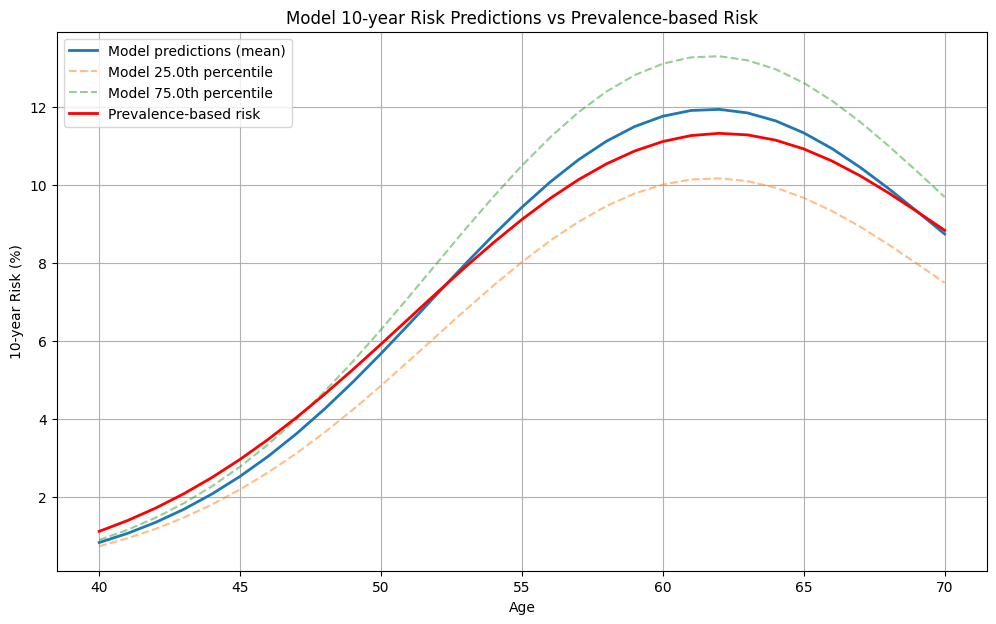


Comparison at specific ages:

Age 40:
Prevalence-based risk: 1.11%
Model mean prediction: 0.82%
Model 25-75th percentile: [0.73%, 0.89%]

Age 50:
Prevalence-based risk: 5.91%
Model mean prediction: 5.67%
Model 25-75th percentile: [4.85%, 6.28%]

Age 60:
Prevalence-based risk: 11.10%
Model mean prediction: 11.75%
Model 25-75th percentile: [10.00%, 13.10%]

Age 70:
Prevalence-based risk: 8.83%
Model mean prediction: 8.73%
Model 25-75th percentile: [7.48%, 9.68%]


In [43]:
# Calculate prevalence-based risks
prev_10yr_risk = calculate_prevalence_10yr_risk(first_model)

plt.figure(figsize=(12, 7))

# Plot average model predictions
plt.plot(range(40, 71), model_risks.mean(), 
         label='Model predictions (mean)', 
         linewidth=2)

# Plot prediction quantiles
quantiles = [0.25, 0.75]
for q in quantiles:
    plt.plot(range(40, 71), model_risks.quantile(q), 
            '--', alpha=0.5,
            label=f'Model {q*100}th percentile')

# Plot prevalence-based risk
plt.plot(range(40, 71), prev_10yr_risk, 
         'r-', label='Prevalence-based risk',
         linewidth=2)

plt.xlabel('Age')
plt.ylabel('10-year Risk (%)')
plt.title('Model 10-year Risk Predictions vs Prevalence-based Risk')
plt.legend()
plt.grid(True)
plt.show()

# Print some numerical comparisons
print("\nComparison at specific ages:")
for age in [40, 50, 60, 70]:
    idx = age - 40
    print(f"\nAge {age}:")
    print(f"Prevalence-based risk: {prev_10yr_risk[idx]:.2f}%")
    print(f"Model mean prediction: {model_risks[age].mean():.2f}%")
    print(f"Model 25-75th percentile: [{model_risks[age].quantile(0.25):.2f}%, {model_risks[age].quantile(0.75):.2f}%]")

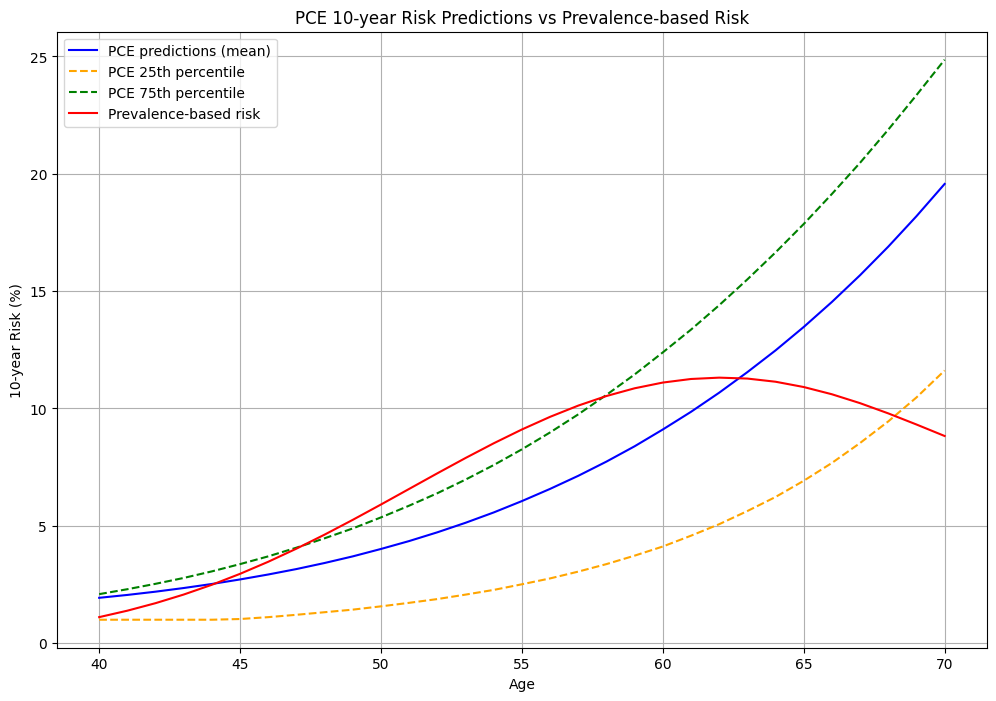

In [44]:
# Get PCE predictions for ages 40-70 only
pce_mean = pce_subset.iloc[:, :31].mean()  # first 31 columns (40-70)
pce_25 = pce_subset.iloc[:, :31].quantile(0.25)
pce_75 = pce_subset.iloc[:, :31].quantile(0.75)

# Create the plot
plt.figure(figsize=(12, 8))
plt.plot(range(40, 71), pce_mean, label='PCE predictions (mean)', color='blue')
plt.plot(range(40, 71), pce_25, '--', label='PCE 25th percentile', color='orange')
plt.plot(range(40, 71), pce_75, '--', label='PCE 75th percentile', color='green')
plt.plot(range(40, 71),prev_10yr_risk, 'r-', label='Prevalence-based risk')

plt.xlabel('Age')
plt.ylabel('10-year Risk (%)')
plt.title('PCE 10-year Risk Predictions vs Prevalence-based Risk')
plt.grid(True)
plt.legend()
plt.show()

In [38]:
print("\nFirst few model predictions (%) up to age 70:")
print(model_risks.head())
print("\nCorresponding PCE predictions:")
print(pce_subset.iloc[:, :31].head())  # Show only up to age 70
max_age=70
ascvd_indices = [111, 112, 113, 114, 115, 116]
mu_dt = first_model['prevalence_t'][ascvd_indices]  # [6 conditions, 52 timepoints]
n_ages = max_age - 40 + 1
ten_year_risks = np.zeros(n_ages)

age_offset = 10  # Start at age 40 (index 10) in prevalence data
    
for age_idx in range(n_ages):
    # Get 10 years of prevalence starting at this age
    start_idx = age_idx + age_offset
    time_window = slice(start_idx, start_idx + 10)
    window_prev = mu_dt[:, time_window]  # [6 conditions, 10 years]
    
    # Calculate survival probability across all conditions and years
    survival_prob = np.prod(1 - window_prev)
    
    # 10-year risk is 1 - survival probability
    ten_year_risks[age_idx] = (1 - survival_prob) * 100  # percentage


First few model predictions (%) up to age 70:
               40        41        42        43        44        45        46  \
5021715  0.772555  0.992946  1.259369  1.577245  1.951141  2.384706  2.880056   
5021723  0.756663  0.969537  1.225402  1.528862  1.883676  2.292724  2.757484   
5021737  0.966054  1.241633  1.573316  1.967072  2.427699  2.958900  3.562614   
5021742  0.804968  1.037676  1.319158  1.654768  2.048748  2.504170  3.022317   
5021759  0.853533  1.098250  1.393358  1.744293  2.155410  2.629972  3.169525   

               47        48        49  ...         61         62         63  \
5021715  3.437140  4.052987  4.722013  ...  11.503464  11.517946  11.415817   
5021723  3.277504  3.849771  4.469010  ...  10.653107  10.660418  10.561979   
5021737  4.238345  4.982399  5.788526  ...  14.377293  14.493802  14.471570   
5021742  3.602081  4.239287  4.927167  ...  11.608382  11.602061  11.480418   
5021759  3.773255  4.437269  5.155088  ...  12.321156  12.347787  12.25

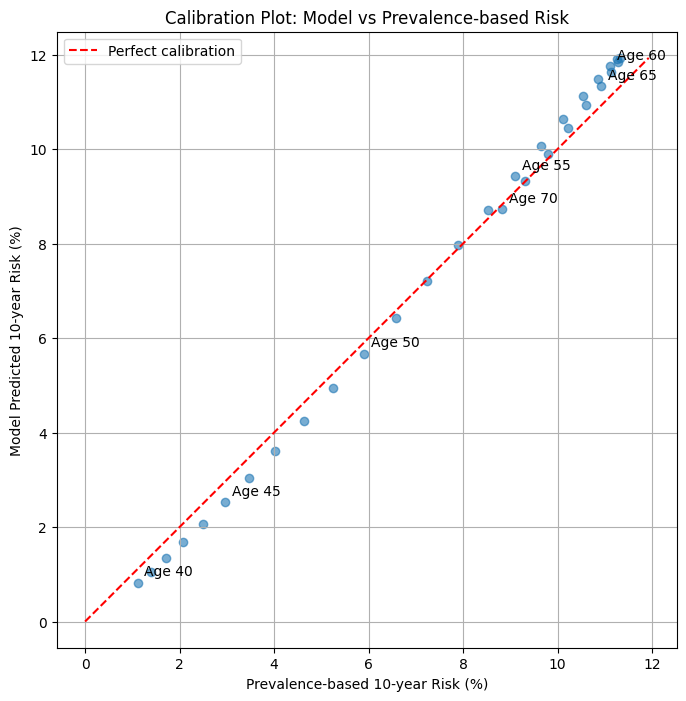

R² score: 0.987

Risk comparisons at key ages:
Age 40: Prevalence = 1.11%, Model = 0.82%
Age 50: Prevalence = 5.91%, Model = 5.67%
Age 60: Prevalence = 11.10%, Model = 11.75%
Age 70: Prevalence = 8.83%, Model = 8.73%


In [46]:
# Get model predictions and prevalence risks
model_means = model_risks.mean()  # This is indexed by age (40-70)
prev_risks = pd.Series(prev_10yr_risk, index=range(40, 71))  # Make prev_risks match the age indexing

plt.figure(figsize=(8, 8))

# Scatter plot of predicted vs actual
plt.scatter(prev_risks, model_means, alpha=0.6)

# Add diagonal reference line
max_risk = max(max(prev_risks), max(model_means))
plt.plot([0, max_risk], [0, max_risk], 'r--', label='Perfect calibration')

# Add labels and title
plt.xlabel('Prevalence-based 10-year Risk (%)')
plt.ylabel('Model Predicted 10-year Risk (%)')
plt.title('Calibration Plot: Model vs Prevalence-based Risk')

# Add age labels to points
for age in range(40, 71, 5):
    plt.annotate(f'Age {age}', 
                (prev_risks[age], model_means[age]),
                xytext=(5, 5), textcoords='offset points')

plt.grid(True)
plt.axis('equal')
plt.legend()
plt.show()

# Print calibration metrics
from sklearn.metrics import r2_score
print(f"R² score: {r2_score(prev_risks, model_means):.3f}")
print("\nRisk comparisons at key ages:")
for age in [40, 50, 60, 70]:
    print(f"Age {age}: Prevalence = {prev_risks[age]:.2f}%, Model = {model_means[age]:.2f}%")

## SO now we've shown well calibrated, but we need to compare calibration

# load in covariates df so we get the ages of enrollment

In [48]:
# Read the covariate file
covariates_df = pd.read_csv('/Users/sarahurbut/Dropbox (Personal)/for_regenie/ukbb_covariates_400k.txt', 
                           delim_whitespace=True,
                           header=0)

# Convert identifier to index
covariates_df.set_index('identifier', inplace=True)

# Convert enrollment date to year
covariates_df['enrollment_year'] = pd.to_datetime(covariates_df['enrollment']).dt.year

# Calculate enrollment age
covariates_df['enrollment_age'] = covariates_df['enrollment_year'] - covariates_df['birth_year']

# Print first few rows to verify
print("First few rows:")
print(covariates_df.head())

# Print basic statistics
print("\nEnrollment age statistics:")
print(covariates_df['enrollment_age'].describe())

/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_171/3234459594.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  covariates_df = pd.read_csv('/Users/sarahurbut/Dropbox (Personal)/for_regenie/ukbb_covariates_400k.txt',


First few rows:
            sex  birth_year  enrollment       PC1      PC2       PC3  \
identifier                                                             
1000015       1        1938  2008-07-23 -12.02340  3.25100  1.224590   
1000023       1        1963  2008-09-11 -14.07040  2.83809 -1.709870   
1000037       0        1939  2009-01-22 -15.00630  4.03881 -1.711670   
1000042       1        1942  2009-11-13 -12.08720  6.29019 -1.486040   
1000059       0        1954  2009-05-20  -9.58886  3.77243  0.274298   

                 PC4      PC5       PC6       PC7  ...      PC13      PC14  \
identifier                                         ...                       
1000015     4.776840  2.31802  2.445040 -3.067290  ...  0.161407 -2.293140   
1000023    -0.782455 -7.93571 -2.176480 -0.688286  ... -1.566490  0.139009   
1000037     6.200160 -2.77040  0.809991  1.012190  ...  1.865970  4.176570   
1000042    -3.426860 -5.35913 -0.146506  2.788340  ... -0.624147 -1.642880   
1000059    

In [50]:
from sklearn.metrics import roc_auc_score

In [56]:
def calculate_enrollment_age_roc(model_risks, pce_subset, Y, patient_ids, common_ids, covariates_df):
    """
    Calculate ROC curves using predictions at enrollment age for each patient
    """
    # Debug info
    print("First few common_ids:", list(common_ids)[:5])
    #print("These IDs should already be in covariates_df:", all(id in covariates_df.index for id in list(common_ids)))

      # Convert common_ids to integers to match covariates_df index type
    common_ids_int = [int(id) for id in common_ids]
    ascvd_indices = [111, 112, 113, 114, 115, 116] 
    print("First few common_ids as integers:", common_ids_int[:5])
    print("First few covariates indices:", list(covariates_df.index)[:5])
    print("These IDs should already be in covariates_df:", all(id in covariates_df.index for id in list(common_ids_int)))

    # Get enrollment ages using integer IDs
    enrollment_ages = covariates_df.loc[common_ids_int, 'enrollment_age'].round().astype(int)
    
    # Get enrollment ages directly - no conversion needed
    print(f"\nFound enrollment ages for {len(enrollment_ages)} patients")
    print("Age range:", enrollment_ages.min(), "to", enrollment_ages.max())
    
    # Initialize arrays for predictions
    our_preds = []
    pce_preds = []
    valid_outcomes = []
    
    # For each patient, get their prediction at enrollment age
    for patient_idx, (patient_id, age) in enumerate(zip(common_ids, enrollment_ages)):
        if age in model_risks and age in pce_subset.columns:
            # Get predictions at enrollment age
            our_preds.append(model_risks[age][patient_idx])
            pce_preds.append(pce_subset.loc[patient_id, age])
            
            # Get outcomes starting from enrollment age
            start_idx = age - 30  # Convert age to index
            if start_idx >= 0 and start_idx + 10 <= Y.shape[2]:
                outcome = torch.any(Y[patient_idx, ascvd_indices, start_idx:start_idx+10])
                valid_outcomes.append(outcome.item())
    
    print(f"\nCollected predictions for {len(valid_outcomes)} patients")
    
    # Convert to numpy arrays
    our_preds = np.array(our_preds)
    pce_preds = np.array(pce_preds)
    valid_outcomes = np.array(valid_outcomes)
    
    # Calculate AUC
    our_auc = roc_auc_score(valid_outcomes, our_preds)
    pce_auc = roc_auc_score(valid_outcomes, pce_preds)
    
    print(f"\nAUC scores:")
    print(f"Our model: {our_auc:.3f}")
    print(f"PCE: {pce_auc:.3f}")
    
    return our_auc, pce_auc, our_preds, pce_preds, valid_outcomes, common_ids

# Use the function
results = calculate_enrollment_age_roc(
    model_risks, 
    pce_subset, 
    Y, 
    patient_ids, 
    common_ids,
    covariates_df
)

First few common_ids: ['5021715', '5021723', '5021737', '5021742', '5021759']
First few common_ids as integers: [5021715, 5021723, 5021737, 5021742, 5021759]
First few covariates indices: [1000015, 1000023, 1000037, 1000042, 1000059]
These IDs should already be in covariates_df: True

Found enrollment ages for 59896 patients
Age range: 40 to 72


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_171/3296499205.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  our_preds.append(model_risks[age][patient_idx])



Collected predictions for 59854 patients

AUC scores:
Our model: 0.586
PCE: 0.570


### Here we calculate for *everyone* with their age adjusted socre

Age 40: Our AUC = 0.674, PCE AUC = 0.651

Time-dependent ROC ID checks:
Number of patients in Y after mask: 59896
Number of predictions in model_risks: 59896
Number of predictions in pce_subset: 59896

First few patient IDs:
In patient_ids (masked): ['5021715' '5021723' '5021737' '5021742' '5021759']
In model_risks: Index(['5021715', '5021723', '5021737', '5021742', '5021759'], dtype='object')
In pce_subset: Index(['5021715', '5021723', '5021737', '5021742', '5021759'], dtype='object')
Age 41: Our AUC = 0.676, PCE AUC = 0.657

Time-dependent ROC ID checks:
Number of patients in Y after mask: 59896
Number of predictions in model_risks: 59896
Number of predictions in pce_subset: 59896

First few patient IDs:
In patient_ids (masked): ['5021715' '5021723' '5021737' '5021742' '5021759']
In model_risks: Index(['5021715', '5021723', '5021737', '5021742', '5021759'], dtype='object')
In pce_subset: Index(['5021715', '5021723', '5021737', '5021742', '5021759'], dtype='object')
Age 42: Our AUC = 

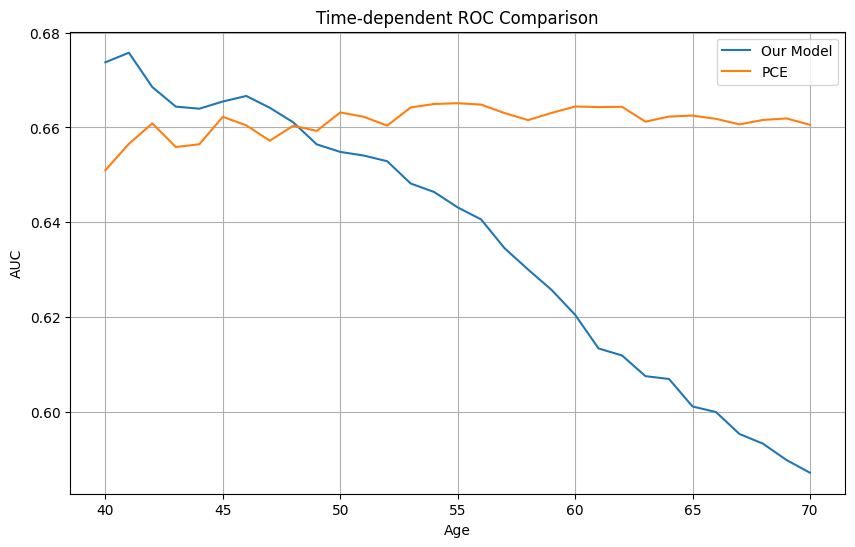

In [114]:
from sklearn.metrics import roc_auc_score

def calculate_time_dependent_roc(model_risks, pce_subset, Y, patient_ids, common_ids, ages=range(40, 71)):
    """
    Calculate ROC curves for both models at each age
    """
    # Get ASCVD events for our subset of patients
    ascvd_indices = [111, 112, 113, 114, 115, 116]
    
    # First subset Y to first 400K patients
    Y_subset = Y[:400000]
    
    # Then get our common patients
    patient_mask = np.isin(patient_ids, common_ids)
    ascvd_events = Y_subset[patient_mask][:, ascvd_indices]
    
    results = []
    for age in ages:
        # Get predictions at this age
        our_preds = model_risks[age].values  # Convert to numpy
        pce_preds = pce_subset[age].values   # Convert to numpy
        
        # Get outcomes in next 10 years from this age
        start_idx = age - 30  # Convert age to index
        # Use torch operations for the 3D tensor
        outcome = torch.any(torch.any(ascvd_events[..., start_idx:start_idx+10], dim=1), dim=1)
        outcome = outcome.numpy()  # Convert to numpy for sklearn
        
        # Calculate AUC for both models
        our_auc = roc_auc_score(outcome, our_preds)
        pce_auc = roc_auc_score(outcome, pce_preds)
        
        results.append({
            'age': age,
            'our_auc': our_auc,
            'pce_auc': pce_auc
        })
        
        # Print progress
        print(f"Age {age}: Our AUC = {our_auc:.3f}, PCE AUC = {pce_auc:.3f}")

            # Add checks for first age (40)
        
        print("\nTime-dependent ROC ID checks:")
        print(f"Number of patients in Y after mask: {ascvd_events.shape[0]}")
        print(f"Number of predictions in model_risks: {len(our_preds)}")
        print(f"Number of predictions in pce_subset: {len(pce_preds)}")
        
        # Check first few IDs match
        print("\nFirst few patient IDs:")
        masked_patient_ids = patient_ids[patient_mask]
        print("In patient_ids (masked):", masked_patient_ids[:5])
        print("In model_risks:", model_risks[age].index[:5])
        print("In pce_subset:", pce_subset.index[:5])
    
    return pd.DataFrame(results)

# Calculate ROCs
roc_results = calculate_time_dependent_roc(model_risks, pce_subset, Y, patient_ids, common_ids)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(roc_results['age'], roc_results['our_auc'], label='Our Model')
plt.plot(roc_results['age'], roc_results['pce_auc'], label='PCE')
plt.xlabel('Age')
plt.ylabel('AUC')
plt.title('Time-dependent ROC Comparison')
plt.legend()
plt.grid(True)
plt.show()

# now we do for the patients who enorlled at exactly taht age

In [115]:
def calculate_time_dependent_roc_by_enrollment(model_risks, pce_subset, Y, patient_ids, common_ids, covariates_df, ages=range(40, 71)):
    """
    Calculate ROC curves for both models at each age, only using patients who enrolled at that age
    """
    ascvd_indices = [111, 112, 113, 114, 115, 116]
    
    # Convert common_ids to integers and get enrollment ages
    common_ids_int = [int(id) for id in common_ids]
    enrollment_ages = covariates_df.loc[common_ids_int, 'enrollment_age'].round().astype(int)
    
    results = []
    for age in ages:
        # Only include patients who enrolled at this age
        age_mask = (enrollment_ages == age)
        current_patients = np.array(common_ids)[age_mask]
        
        if len(current_patients) == 0:
            continue
            
        # Get predictions for these patients
        # Make sure we're using the same index for both
        our_preds = model_risks[age].loc[current_patients]  # Use loc with patient IDs
        pce_preds = pce_subset.loc[current_patients, age]
        
        # Get outcomes in next 10 years
        start_idx = age - 30
        patient_indices = np.where(np.isin(patient_ids, current_patients))[0]
        outcome = torch.any(Y[patient_indices][:, ascvd_indices, start_idx:start_idx+10], dim=(1,2))
        
        # Calculate AUC for both models
        our_auc = roc_auc_score(outcome, our_preds)
        pce_auc = roc_auc_score(outcome, pce_preds)

        #if age == 40:
        print("\nEnrollment-based ROC ID checks:")
        print(f"Number of patients enrolled at age 40: {len(current_patients)}")
        print(f"Number of predictions from model_risks: {len(our_preds)}")
        print(f"Number of predictions from pce_subset: {len(pce_preds)}")
        print(f"Number of outcomes: {len(outcome)}")
        
        # Check first few IDs match
        print("\nFirst few patient IDs:")
        print("Current patients:", current_patients[:5])
        print("In model_risks:", our_preds.index[:5])
        print("In pce_subset:", pce_preds.index[:5])
        print("Patient indices in Y:", patient_ids[patient_indices][:5])
        
        results.append({
            'age': age,
            'our_auc': our_auc,
            'pce_auc': pce_auc,
            'n_patients': len(current_patients)
        })
        
        print(f"Age {age}: n={len(current_patients)}, Our AUC = {our_auc:.3f}, PCE AUC = {pce_auc:.3f}")
    
    return pd.DataFrame(results)

/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(



Enrollment-based ROC ID checks:
Number of patients enrolled at age 40: 185
Number of predictions from model_risks: 185
Number of predictions from pce_subset: 185
Number of outcomes: 185

First few patient IDs:
Current patients: ['5027944' '5039638' '5041460' '5047034' '5048450']
In model_risks: Index(['5027944', '5039638', '5041460', '5047034', '5048450'], dtype='object')
In pce_subset: Index(['5027944', '5039638', '5041460', '5047034', '5048450'], dtype='object')
Patient indices in Y: ['5027944' '5039638' '5041460' '5047034' '5048450']
Age 40: n=185, Our AUC = nan, PCE AUC = nan

Enrollment-based ROC ID checks:
Number of patients enrolled at age 40: 854
Number of predictions from model_risks: 854
Number of predictions from pce_subset: 854
Number of outcomes: 854

First few patient IDs:
Current patients: ['5022675' '5024809' '5025916' '5027988' '5030237']
In model_risks: Index(['5022675', '5024809', '5025916', '5027988', '5030237'], dtype='object')
In pce_subset: Index(['5022675', '50

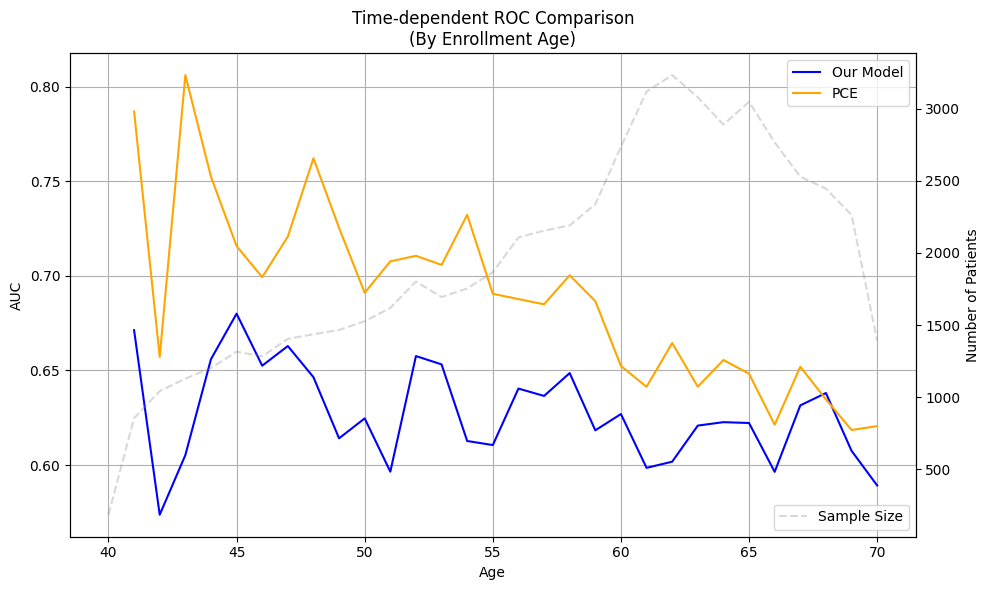

In [116]:
# Calculate ROCs with enrollment age binning
roc_results = calculate_time_dependent_roc_by_enrollment(
    model_risks, pce_subset, Y, patient_ids, common_ids, covariates_df
)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot AUC lines
plt.plot(roc_results['age'], roc_results['our_auc'], label='Our Model', color='blue')
plt.plot(roc_results['age'], roc_results['pce_auc'], label='PCE', color='orange')

# Add grid and labels
plt.xlabel('Age')
plt.ylabel('AUC')
plt.title('Time-dependent ROC Comparison\n(By Enrollment Age)')
plt.legend()
plt.grid(True)

# Optional: Add sample size information
ax2 = plt.twinx()  # Create second y-axis
ax2.plot(roc_results['age'], roc_results['n_patients'], 
         color='gray', alpha=0.3, linestyle='--', label='Sample Size')
ax2.set_ylabel('Number of Patients')
ax2.legend(loc='lower right')

plt.tight_layout()
plt.show()

In [112]:
def calculate_enrollment_age_roc_by_bins(model_risks, pce_subset, Y, patient_ids, common_ids, covariates_df):
    """
    Calculate ROC curves using predictions at enrollment age for each patient, binned by age groups
    """
    # Convert common_ids to integers and get enrollment ages
    common_ids_int = [int(id) for id in common_ids]
    enrollment_ages = covariates_df.loc[common_ids_int, 'enrollment_age'].round().astype(int)
    
    # Define age bins
    age_bins = [(40,45), (45,50), (50,55), (55,60), (60,65)]
    results = []
    
    for start_age, end_age in age_bins:
        # Initialize arrays for this age bin
        our_preds = []
        pce_preds = []
        valid_outcomes = []
        debug_ids = []  # Add this to store IDs for checking
        
        # Get patients in this age range
        for patient_idx, (patient_id, age) in enumerate(zip(common_ids, enrollment_ages)):
            if start_age <= age < end_age and age in model_risks and age in pce_subset.columns:
                # Get predictions at enrollment age
                our_preds.append(model_risks[age].loc[patient_id])  # Use .loc with patient ID
                pce_preds.append(pce_subset.loc[patient_id, age])
                
                # Get outcomes starting from enrollment age
                start_idx = age - 30
                if start_idx >= 0 and start_idx + 10 <= Y.shape[2]:
                    actual_idx = np.where(patient_ids == patient_id)[0][0]
                    outcome = torch.any(Y[actual_idx,ascvd_indices, start_idx:start_idx+10])
                    valid_outcomes.append(outcome.item())
                    debug_ids.append(patient_id)  # Store ID for checking

        # Debug prints for this bin - moved outside the inner loop
        print(f"\nBinned ROC ID checks for ages {start_age}-{end_age}:")
        print(f"Number of patients in bin: {len(valid_outcomes)}")
        print(f"Number of predictions (our model): {len(our_preds)}")
        print(f"Number of predictions (PCE): {len(pce_preds)}")
        
        print("\nFirst few patient IDs:")
        print("Patient IDs being used:", debug_ids[:5])
        indices_in_Y = [np.where(patient_ids == pid)[0][0] for pid in debug_ids[:5]]
        print("Indices in Y:", indices_in_Y)
        print("Patient IDs at those indices in Y:", [patient_ids[idx] for idx in indices_in_Y])
        print("Values from our_preds:", our_preds[:5])
        print("Values from pce_preds:", pce_preds[:5])

        if len(valid_outcomes) > 0:  # Only calculate if we have data
            # Convert to numpy arrays
            our_preds = np.array(our_preds)
            pce_preds = np.array(pce_preds)
            valid_outcomes = np.array(valid_outcomes)
            
            # Calculate AUC for this bin
            our_auc = roc_auc_score(valid_outcomes, our_preds)
            pce_auc = roc_auc_score(valid_outcomes, pce_preds)
            
            results.append({
                'age_bin': f'{start_age}-{end_age}',
                'n_patients': len(valid_outcomes),
                'our_auc': our_auc,
                'pce_auc': pce_auc
            })
            
            print(f"\nResults for age {start_age}-{end_age}:")
            print(f"Number of patients: {len(valid_outcomes)}")
            print(f"Our model AUC: {our_auc:.3f}")
            print(f"PCE AUC: {pce_auc:.3f}")
    
    return pd.DataFrame(results)


Binned ROC ID checks for ages 40-45:
Number of patients in bin: 4411
Number of predictions (our model): 4411
Number of predictions (PCE): 4411

First few patient IDs:
Patient IDs being used: ['5021790', '5021828', '5021847', '5022173', '5022381']
Indices in Y: [np.int64(326448), np.int64(326451), np.int64(326452), np.int64(326479), np.int64(326498)]
Patient IDs at those indices in Y: [np.str_('5021790'), np.str_('5021828'), np.str_('5021847'), np.str_('5022173'), np.str_('5022381')]
Values from our_preds: [np.float64(1.6671695411149656), np.float64(1.3850011396749795), np.float64(1.0388338525244567), np.float64(1.7482357643513136), np.float64(1.6283460806754135)]
Values from pce_preds: [np.float64(1.32), np.float64(2.39), np.float64(1.0), np.float64(1.0), np.float64(1.0)]

Results for age 40-45:
Number of patients: 4411
Our model AUC: 0.623
PCE AUC: 0.762

Binned ROC ID checks for ages 45-50:
Number of patients in bin: 6904
Number of predictions (our model): 6904
Number of predictions

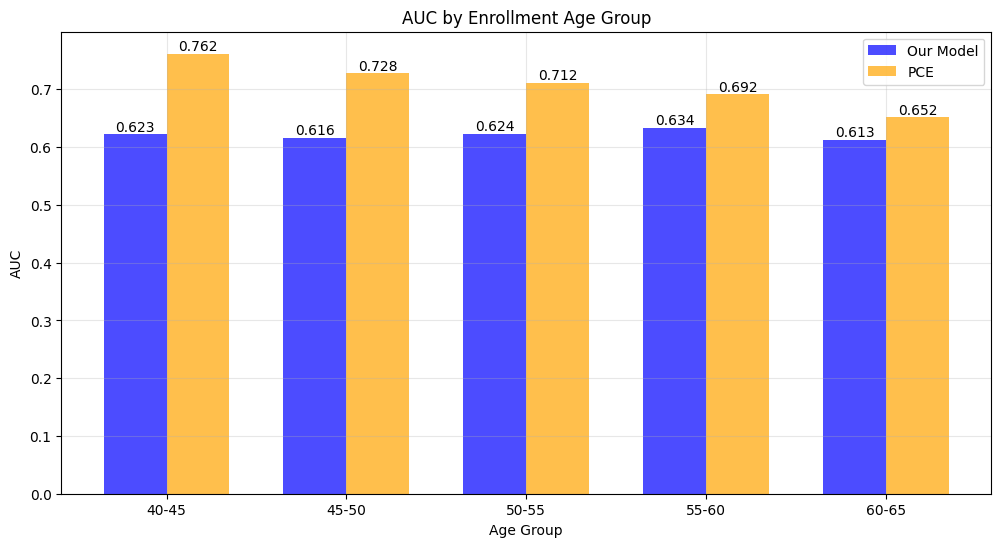


Detailed results:
age_bin  n_patients  our_auc  pce_auc
  40-45        4411 0.622574 0.761676
  45-50        6904 0.616202 0.727531
  50-55        8393 0.623565 0.711574
  55-60       10654 0.633589 0.691559
  60-65       15052 0.612997 0.651690


In [113]:
# Calculate AUCs by age bin
results_by_age = calculate_enrollment_age_roc_by_bins(
    model_risks, 
    pce_subset, 
    Y, 
    patient_ids, 
    common_ids,
    covariates_df
)

# Plot the results
plt.figure(figsize=(12, 6))
x = range(len(results_by_age))
width = 0.35

plt.bar([i - width/2 for i in x], results_by_age['our_auc'], width, label='Our Model', color='blue', alpha=0.7)
plt.bar([i + width/2 for i in x], results_by_age['pce_auc'], width, label='PCE', color='orange', alpha=0.7)

plt.xlabel('Age Group')
plt.ylabel('AUC')
plt.title('AUC by Enrollment Age Group')
plt.xticks(x, results_by_age['age_bin'])
plt.legend()
plt.grid(True, alpha=0.3)

# Add value labels on top of bars
for i in x:
    plt.text(i - width/2, results_by_age['our_auc'].iloc[i], f"{results_by_age['our_auc'].iloc[i]:.3f}", 
             ha='center', va='bottom')
    plt.text(i + width/2, results_by_age['pce_auc'].iloc[i], f"{results_by_age['pce_auc'].iloc[i]:.3f}", 
             ha='center', va='bottom')

plt.show()

# Print detailed results
print("\nDetailed results:")
print(results_by_age.to_string(index=False))

Age 40: Our AUC = 0.674, PCE AUC = 0.651
Age 41: Our AUC = 0.676, PCE AUC = 0.657
Age 42: Our AUC = 0.668, PCE AUC = 0.661
Age 43: Our AUC = 0.664, PCE AUC = 0.656
Age 44: Our AUC = 0.664, PCE AUC = 0.656
Age 45: Our AUC = 0.665, PCE AUC = 0.662
Age 46: Our AUC = 0.667, PCE AUC = 0.660
Age 47: Our AUC = 0.664, PCE AUC = 0.657
Age 48: Our AUC = 0.661, PCE AUC = 0.660
Age 49: Our AUC = 0.656, PCE AUC = 0.659
Age 50: Our AUC = 0.655, PCE AUC = 0.663
Age 51: Our AUC = 0.654, PCE AUC = 0.662
Age 52: Our AUC = 0.653, PCE AUC = 0.660
Age 53: Our AUC = 0.648, PCE AUC = 0.664
Age 54: Our AUC = 0.646, PCE AUC = 0.665
Age 55: Our AUC = 0.643, PCE AUC = 0.665
Age 56: Our AUC = 0.641, PCE AUC = 0.665
Age 57: Our AUC = 0.635, PCE AUC = 0.663
Age 58: Our AUC = 0.630, PCE AUC = 0.662
Age 59: Our AUC = 0.626, PCE AUC = 0.663
Age 60: Our AUC = 0.621, PCE AUC = 0.664
Age 61: Our AUC = 0.613, PCE AUC = 0.664
Age 62: Our AUC = 0.612, PCE AUC = 0.664
Age 63: Our AUC = 0.608, PCE AUC = 0.661
Age 64: Our AUC 

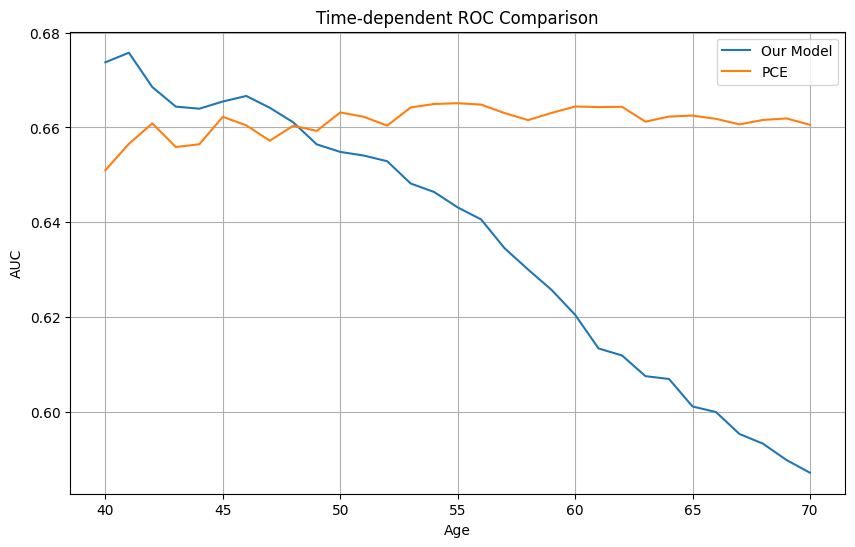

In [82]:
from sklearn.metrics import roc_auc_score

def calculate_time_dependent_roc(model_risks, pce_subset, Y, patient_ids, common_ids, ages=range(40, 71)):
    """
    Calculate ROC curves for both models at each age
    """
    # Get ASCVD events for our subset of patients
    ascvd_indices = [111, 112, 113, 114, 115, 116]
    
    # First subset Y to first 400K patients
    Y_subset = Y[:400000]
    
    # Then get our common patients
    patient_ids_subset = patient_ids[:400000]

# Then create mask using subset
    patient_mask = np.isin(patient_ids_subset, common_ids)
    ascvd_events = Y_subset[patient_mask][:, ascvd_indices]
    
    results = []
    for age in ages:
        # Get predictions at this age
        our_preds = model_risks[age].values  # Convert to numpy
        pce_preds = pce_subset[age].values   # Convert to numpy
        
        # Get outcomes in next 10 years from this age
        start_idx = age - 30  # Convert age to index
        # Use torch operations for the 3D tensor
        outcome = torch.any(torch.any(ascvd_events[..., start_idx:start_idx+10], dim=1), dim=1)
        outcome = outcome.numpy()  # Convert to numpy for sklearn
        
        # Calculate AUC for both models
        our_auc = roc_auc_score(outcome, our_preds)
        pce_auc = roc_auc_score(outcome, pce_preds)
        
        results.append({
            'age': age,
            'our_auc': our_auc,
            'pce_auc': pce_auc
        })
        
        # Print progress
        print(f"Age {age}: Our AUC = {our_auc:.3f}, PCE AUC = {pce_auc:.3f}")
    
    return pd.DataFrame(results)

# Calculate ROCs
roc_results = calculate_time_dependent_roc(model_risks, pce_subset, Y, patient_ids, common_ids)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(roc_results['age'], roc_results['our_auc'], label='Our Model')
plt.plot(roc_results['age'], roc_results['pce_auc'], label='PCE')
plt.xlabel('Age')
plt.ylabel('AUC')
plt.title('Time-dependent ROC Comparison')
plt.legend()
plt.grid(True)
plt.show()

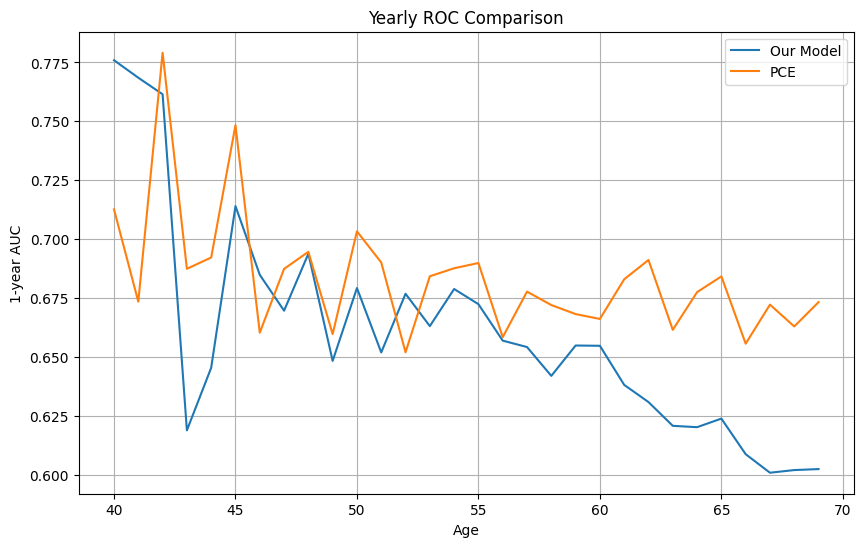

In [69]:
def compute_yearly_roc_comparison(pi, Y, event_times, patient_ids, common_ids, pce_subset, ascvd_indices=[111,112,113,114,115,116]):
    """
    Compare yearly ROCs between our model and PCE for ages 40-70
    """
    # Convert PCE to numpy if it's a DataFrame
    pce_array = pce_subset.values if hasattr(pce_subset, 'values') else pce_subset
    
    # Get common patients
    common_mask = np.isin(patient_ids, common_ids)
    
    # Subset everything to common patients and convert to numpy
    pi_common = pi[common_mask] # Convert torch to numpy
    Y_common = Y[common_mask].detach().numpy() if torch.is_tensor(Y) else Y[common_mask]
    event_times_common = event_times[common_mask].detach().numpy() if torch.is_tensor(event_times) else event_times[common_mask]
    
    # Subset to ASCVD events
    pi_ascvd = pi_common[:, ascvd_indices]*ascvd_scale
    Y_ascvd = Y_common[:, ascvd_indices]
    event_times_ascvd = event_times_common[:, ascvd_indices]
    
    our_aucs = []
    pce_aucs = []
    
    for t in range(10, 40):  # Ages 40-70
        our_pred_t = np.max(pi_ascvd[:,:,t], axis=1)  # Use numpy max
        pce_pred_t = pce_array[:,t-10]
        
        # Events that occur during year t
        events_t = np.max((event_times_ascvd >= t) & (event_times_ascvd < t+1), axis=1)
        
        # Only include individuals at risk
        mask = np.max(event_times_ascvd > t-1, axis=1)
        
        if np.sum(mask) > 0:
            our_auc = roc_auc_score(events_t[mask], our_pred_t[mask])
            pce_auc = roc_auc_score(events_t[mask], pce_pred_t[mask])
            our_aucs.append(our_auc)
            pce_aucs.append(pce_auc)
    
    return our_aucs, pce_aucs

# Usage:
Y_subset = Y[:400000]
E_subset = E[:400000]
our_aucs, pce_aucs = compute_yearly_roc_comparison(
    pi_pred, 
    Y_subset,
    event_times=E_subset,
    patient_ids=patient_ids, 
    common_ids=common_ids,
    pce_subset=pce_subset,
    ascvd_indices=[111,112,113,114,115,116]
)
# Plot with correct ages
plt.figure(figsize=(10,6))
plt.plot(range(40,70), our_aucs, label='Our Model')
plt.plot(range(40,70), pce_aucs, label='PCE')
plt.xlabel('Age')
plt.ylabel('1-year AUC')
plt.legend()
plt.title('Yearly ROC Comparison')
plt.grid(True)



In [71]:
del pi_pred